In [40]:
from pathlib import Path
import os
parent_dir = os.path.dirname(os.getcwd())

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
np.random.seed(1977)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")

In [55]:
def gradient_fill(x, y_low, y_high, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y_high, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y_low.min(), y_high.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y_high])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im


In [2]:
def q_logarithm(input, q):
    '''q-logarithm is undefined for negative input'''
    input[input < 0] = np.nan
    if q == 1:
        return np.log(input)
    else:
        return (input ** (q-1)  - 1) / (q-1)

def q_exponential(input, q):
    if q == 1:
        return np.exp(input)
    else:
        return np.power(np.maximum(1 + (q - 1) * input, 0), 1/(q-1))
    

In [77]:
def sparsemax_operator(input, q):
    kq = 0.5*q
    dim = 0
    # number of dimmension (logits) for sparsemax distribution
    number_of_logits = input.shape[dim]

    # sort the vector in descending order, zs is the naming in the paper (Martins 2016) 
    zs = np.sort(input)[::-1]

    # range is for computation 1 + k * z > sum zj
    range = np.arange(start=1, stop=number_of_logits+1, step=1, dtype=input.dtype).reshape(1, -1)
    # range = np.broadcast_to(range, zs.shape)

    bound = kq + range * zs

    cumulative_sum_zs = np.cumsum(zs, dim)

    # k is the cardinality of the set of allowable actions, see Eq. (4) of sparsemax (Martins 2016)
    is_greater = np.greater(bound, cumulative_sum_zs)
    k = np.maximum(np.max(is_greater * range), 1)

    # threshold function
    zs_sparse = is_greater * zs

    tau = (np.sum(zs_sparse) - kq) / k
    expanded_tau = np.broadcast_to(tau, input.shape)

    policy = np.maximum(np.zeros_like(input), input-expanded_tau) ** (1 / (q-1))
    
    if q != 2:
        policy /= policy.sum()

    return policy, tau


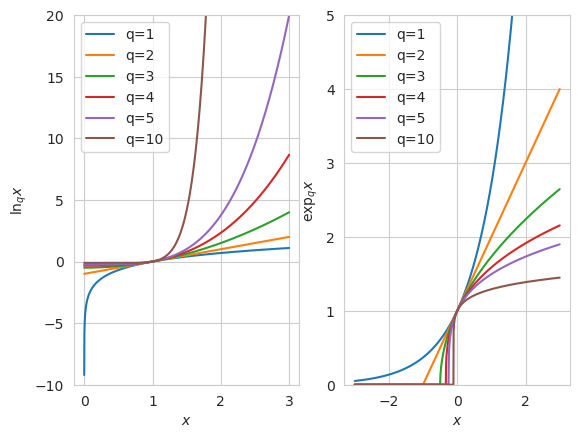

In [19]:
# illustrate q-statistics behavior
q = list(range(1, 6)) + [10]
x1 = np.linspace(-3, 3, 1000)
x2 = np.linspace(0.0001, 3, 1000)

fig, axes = plt.subplots(1, 2)
for ent_idx in q:
    expq_y = q_exponential(x1, ent_idx)
    lnq_y = q_logarithm(x2, ent_idx)

    axes[0].plot(x2, lnq_y, label="q="+str(ent_idx))
    axes[0].set_xlabel(r"$x$")
    axes[0].set_ylabel(r"$\ln_q x$")
    axes[0].set_ylim([-10, 20])
    axes[0].legend()
    
    axes[1].plot(x1, expq_y, label="q="+str(ent_idx))
    axes[1].set_xlabel(r"$x$")
    axes[1].set_ylabel(r"$\exp_q x$")
    axes[1].set_ylim([-0.001, 5.0])
    axes[1].legend()
plt.show()
fig.tight_layout()
fig.savefig(os.path.join(parent_dir, "paper", "img",  "q_stat_illus.png"), dpi=600)
    

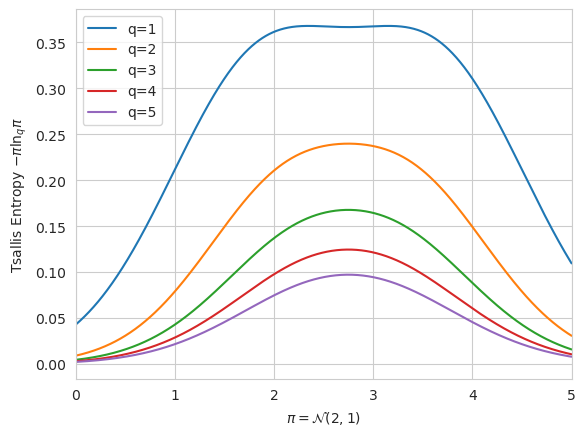

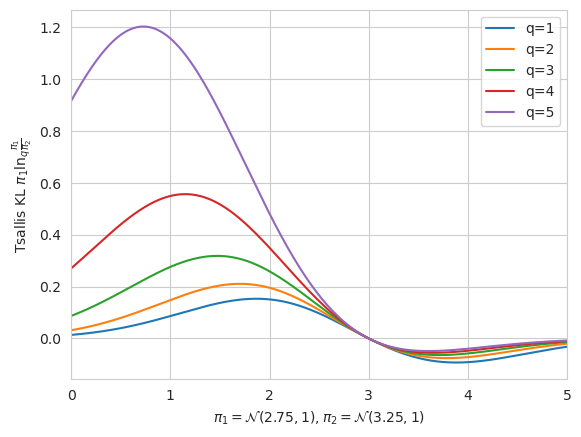

In [20]:
# Tsallis entropy, Tsallis KL of Gaussian variables
q = list(range(1, 6)) 
x = np.linspace(0.001, 5, 1000)
mu1, mu2 = 2.75, 3.25
sigma1, sigma2 = 1., 1.
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))
ent_fig, ent_ax = plt.subplots(1, 1)
kl_fig, kl_ax = plt.subplots(1, 1)
for ent_idx in q:
    tsallis_entropy = - (g1 * q_logarithm(g1, ent_idx))
    ent_ax.plot(x, tsallis_entropy, label="q="+str(ent_idx))

    tsallis_kl = g1 * (q_logarithm(g1/g2, ent_idx))
    kl_ax.plot(x, tsallis_kl, label="q="+str(ent_idx))

ent_ax.legend()
ent_ax.set_xlim([0, 5])
ent_ax.set_xlabel(r"$\pi=\mathcal{N}(2, 1)$")
ent_ax.set_ylabel(r"Tsallis Entropy $-\pi\ln_q \pi$")    

kl_ax.legend()
kl_ax.set_xlim([0, 5])
kl_ax.set_xlabel(r"$\pi_1=\mathcal{N}(2.75, 1), \pi_2=\mathcal{N}(3.25, 1)$")
kl_ax.set_ylabel(r"Tsallis KL $\pi_1 \ln_q \frac{\pi_1}{\pi_2}$")
plt.show()

ent_fig.tight_layout()
kl_fig.tight_layout()
ent_fig.savefig(os.path.join(parent_dir, "paper", "img",  "tsallis_entropy.png"), dpi=600)
kl_fig.savefig(os.path.join(parent_dir, "paper", "img",  "tsallis_kl.png"), dpi=600)
    


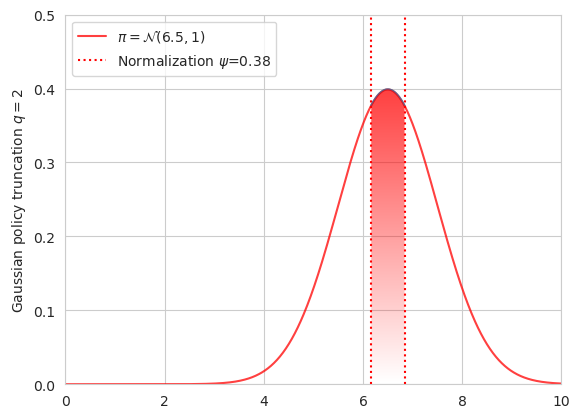

In [104]:
# sparsemax acting upon Gaussian policies
q = list(range(1, 6))
x = np.linspace(0.001, 10, 1000)
mu1, mu2 = 4.5, 6.5
sigma1, sigma2 = 1., 1.
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))

fig, ax = plt.subplots(1, 1)
# for ent_idx in q:
policy, normalization = sparsemax_operator(g2, q=2.0)
ax.plot(x, g2, label=r"$\pi = \mathcal{N}(6.5, 1)$", color='red', alpha=0.75)
positive_idx = np.where(policy>0)[0]

# y = np.vstack([np.zeros_like(positive_idx), g2[policy>0]])
g2[policy>0][0]
gradient_fill(x[positive_idx], np.zeros_like(positive_idx), g2[policy>0], fill_color='red', ax=ax, alpha=0.75)
# ax.fill_between(x[positive_idx], np.zeros_like(positive_idx), g2[policy>0], color='red', alpha=0.25, edgecolor=None)
ax.axvline(x=x[np.where(g2 > normalization)[0][0]],  linestyle=':', label=rf"Normalization $\psi$={normalization:.2f}", color='r')
ax.axvline(x=x[np.where(g2 > normalization)[0][-1]], linestyle=':', color='r')
ax.set_ylabel(r"Gaussian policy truncation $q=2$")
ax.set_ylim([-0.0001, 0.5])
ax.set_xlim([0, 10])
ax.legend()
plt.show()


fig.tight_layout()
fig.savefig(os.path.join(parent_dir, "paper", "img",  "q2_Gaussian_sparsemax.png"), dpi=600)
    

In [53]:
 g2[policy>0]

array([0.37736849, 0.3786111 , 0.37981975, 0.38099409, 0.38213377,
       0.38323847, 0.38430786, 0.38534163, 0.38633947, 0.3873011 ,
       0.38822622, 0.38911457, 0.38996589, 0.39077991, 0.39155641,
       0.39229515, 0.39299591, 0.39365848, 0.39428267, 0.39486829,
       0.39541516, 0.39592313, 0.39639204, 0.39682174, 0.39721212,
       0.39756305, 0.39787442, 0.39814616, 0.39837817, 0.39857038,
       0.39872274, 0.3988352 , 0.39890773, 0.3989403 , 0.3989329 ,
       0.39888555, 0.39879825, 0.39867102, 0.39850391, 0.39829697,
       0.39805026, 0.39776385, 0.39743783, 0.39707229, 0.39666735,
       0.39622313, 0.39573976, 0.39521738, 0.39465616, 0.39405625,
       0.39341784, 0.39274111, 0.39202628, 0.39127355, 0.39048314,
       0.38965529, 0.38879024, 0.38788826, 0.3869496 , 0.38597454,
       0.38496337, 0.38391639, 0.3828339 , 0.38171622, 0.38056368,
       0.37937661, 0.37815535, 0.37690027])

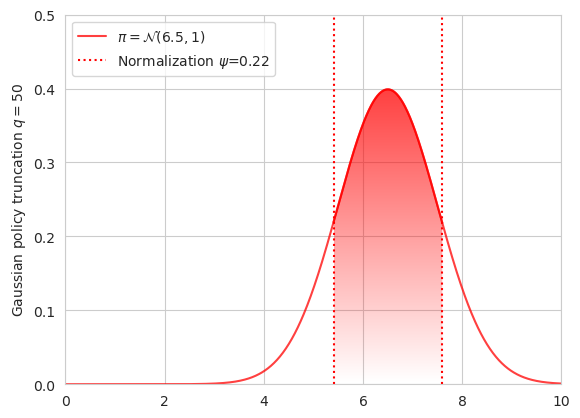

In [103]:
# sparsemax acting upon Gaussian policies, larger q
q = 50
x = np.linspace(0.001, 10, 1000)
mu1, mu2 = 4.5, 6.5
sigma1, sigma2 = 1., 1.
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))

fig, ax = plt.subplots(1, 1)

# g2 /= tau

policy, normalization = sparsemax_operator(g2, q=q)
ax.plot(x, g2, label=r"$\pi = \mathcal{N}(6.5, 1)$", color='red', alpha=0.75)
positive_idx = np.where(policy>0)[0]
gradient_fill(x[positive_idx], np.zeros_like(positive_idx), g2[policy>0], color='red', alpha=0.75)
# ax.fill_between(x[positive_idx], np.zeros_like(positive_idx), g2[policy>0], color='red', alpha=0.75, edgecolor=None)
ax.axvline(x=x[np.where(g2 > normalization)[0][0]],  linestyle=':', label=rf"Normalization $\psi$={normalization:.2f}", color='r')
ax.axvline(x=x[np.where(g2 > normalization)[0][-1]], linestyle=':', color='r')
ax.set_ylabel(rf"Gaussian policy truncation $q={q}$")
ax.set_ylim([-0.0001, 0.5])

ax.set_xlim([0, 10])
ax.legend()
plt.show()

fig.tight_layout()
fig.savefig(os.path.join(parent_dir, "paper", "img",  f"q{q}_scaled_Gaussian_sparsemax.png"), dpi=600)
    

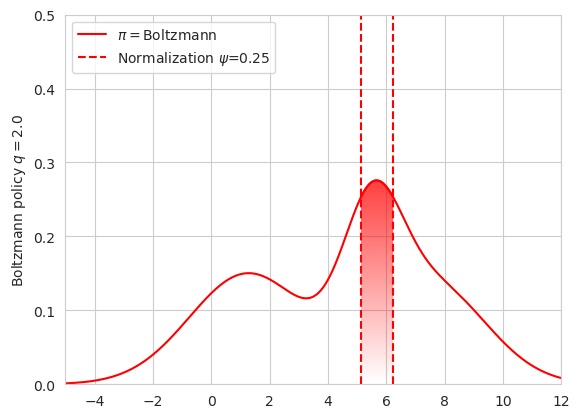

In [102]:
# sparsemax acting upon Boltzmann policies
q=2.0
x = np.linspace(-5, 12, 1000)
mu1, mu2, mu3 = 1.25, 5.5, 7.5
sigma1, sigma2, sigma3 = 2., 1, 1.9
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))
g3 =  1/np.sqrt(2*np.pi*sigma3**2) * np.exp(-(x-mu3)**2/(2*sigma3**2))

boltzmann = 0.75 * g1 + 0.45 * g2 + 0.65 * g3

fig, ax = plt.subplots(1, 1)
policy, normalization = sparsemax_operator(boltzmann, q=q)
ax.plot(x, boltzmann, label=r"$\pi=$Boltzmann", color='red')
positive_idx = np.where(policy>0)[0]
gradient_fill(x[positive_idx], np.zeros_like(positive_idx), boltzmann[policy>0], color='red', alpha=0.75)
ax.axvline(x=x[np.where(boltzmann > normalization)[0][0]],  linestyle='--', label=rf"Normalization $\psi$={normalization:.2f}", color='r')
ax.axvline(x=x[np.where(boltzmann > normalization)[0][-1]], linestyle='--', color='r')
ax.set_ylabel(rf"Boltzmann policy $q={q}$")
ax.set_ylim([-0.0001, 0.5])
ax.set_xlim([-5, 12])
ax.legend()
plt.show()


fig.tight_layout()
fig.savefig(os.path.join(parent_dir, "paper", "img",  f"q{q}_Boltzmann_sparsemax.png"), dpi=600)

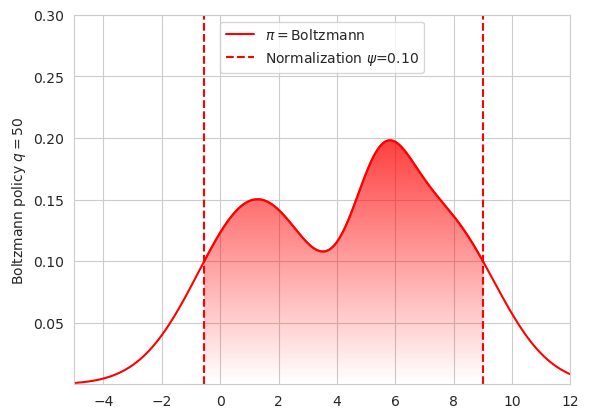

In [100]:
# sparsemax acting upon Boltzmann policies, controlling the scale
q=50
x = np.linspace(-5, 12, 1000)
mu1, mu2, mu3 = 1.25, 5.5, 7.5
sigma1, sigma2, sigma3 = 2., 1, 1.9
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))
g3 =  1/np.sqrt(2*np.pi*sigma3**2) * np.exp(-(x-mu3)**2/(2*sigma3**2))

boltzmann = 0.75 * g1 + 0.25 * g2 + 0.65 * g3


fig, ax = plt.subplots(1, 1)
policy, normalization = sparsemax_operator(boltzmann, q=q)
# ax.plot(x[np.where(boltzmann < normalization)[0]], boltzmann[np.where(boltzmann < normalization)[0]], label=r"$\pi=$Boltzmann", color='red')
ax.plot(x, boltzmann, label=r"$\pi=$Boltzmann", color='red')
positive_idx = np.where(policy>0)[0]
gradient_fill(x[positive_idx], np.zeros_like(positive_idx), boltzmann[policy>0], color='red', alpha=0.75)
ax.axvline(x=x[np.where(boltzmann > normalization)[0][0]],  linestyle='--', label=rf"Normalization $\psi$={normalization:.2f}", color='r')
ax.axvline(x=x[np.where(boltzmann > normalization)[0][-1]], linestyle='--', color='r')
ax.set_ylabel(rf"Boltzmann policy $q={q}$")
ax.set_xlim([-5, 12])
ax.set_ylim([0.0001, 0.3])
ax.legend()
plt.show()


fig.tight_layout()
fig.savefig(os.path.join(parent_dir, "paper", "img",  f"q{q}_Boltzmann_sparsemax.png"), dpi=600)